# Data Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

wec_data = pd.read_excel('ARIN1 copy.xlsx')
wec_data.columns = ['time', 'wem'] #in sec and Nm, respectively
wec_data.head()

,time,wem
0,0.05,-0.241213
1,0.10,0.353760
2,0.15,0.538115
3,0.20,0.706059
4,0.25,0.629762


In [2]:
time = wec_data['time'].values
wem = wec_data['wem'].values

# Modelling Wave properties

In [3]:
# This cell defines and applies key signal processing and control functions for the wave energy converter (WEC) project.
# 
# 1. It implements an Extended Kalman Filter (EKF) to estimate the instantaneous amplitude (amp_ekf) and frequency (omega_ekf) of the measured Wave Excitation Moment (wem) signal.
# 2. Using these estimates, it computes the optimal reference angular velocity (theta_dot_ref) for the WEC, which is crucial for maximizing energy extraction.
# 3. It calculates the instantaneous power and cumulative extracted energy from the WEC based on the reference velocity and measured wem.
# 4. The cell also provides utility functions for further analysis, such as computing the inverse wave period (T_inv).
#
# These steps are essential for real-time control and performance evaluation of the WEC, enabling adaptive optimization based on the actual wave conditions.

import numpy as np

def ekf_amplitude_frequency(wem, Ts):

    #extended kalman filter 

    n = len(wem)
    A_ex = np.zeros(n)
    omega = np.zeros(n)
    
    psi, psi_star, w = wem[0], wem[0], 5.0
    P = np.eye(3) * 0.1
    Q = np.diag([0.2, 0.2, 0.001])
    R = 0.1
    
    for k in range(n):
        cos_wTs = np.cos(w * Ts)
        sin_wTs = np.sin(w * Ts)
        psi_pred = cos_wTs * psi + sin_wTs * psi_star
        psi_star_pred = -sin_wTs * psi + cos_wTs * psi_star
        w_pred = w
        x_pred = np.array([psi_pred, psi_star_pred, w_pred])
        
        F = np.array([
            [cos_wTs, sin_wTs, Ts * (-sin_wTs * psi + cos_wTs * psi_star)],
            [-sin_wTs, cos_wTs, Ts * (-cos_wTs * psi - sin_wTs * psi_star)],
            [0, 0, 1]
        ])
        
        P = F @ P @ F.T + Q
        
        y = wem[k]
        H = np.array([[1, 0, 0]])
        S = H @ P @ H.T + R
        K = P @ H.T @ np.linalg.inv(S)
        x_upd = x_pred + K.flatten() * (y - H @ x_pred)
        P = (np.eye(3) - K @ H) @ P
        
        psi, psi_star, w = x_upd
        A_ex[k] = np.sqrt(psi**2 + psi_star**2)
        omega[k] = w
    
    return A_ex, omega #rad/s


def compute_reference_velocity(M_ex, A_ex, omega,
                                B_omega=0.5, K_v0=1.8, theta_lim=0.4):
    """
    Computes reference angular velocity θ̇_ref based on WEM estimates.
    """
    T_inv = np.where(
        (omega * theta_lim / A_ex) > 1 / (2 * B_omega + 2 * K_v0),
        1 / (2 * B_omega + 2 * K_v0),
        (omega * theta_lim) / A_ex
    )
    return T_inv * M_ex

def compute_power_energy(theta_dot_ref, M_ex, Ts=0.05, mu_gen=0.7):
    """
    Compute power and cumulative extracted energy using reference velocity.
    """
    power = mu_gen * M_ex * theta_dot_ref
    energy = np.cumsum(power) * Ts
    return power, energy

def compute_T_inv(M_ex, A_ex, omega,
                        B_omega=0.5, K_v0=1.8, theta_lim=0.4):
    """
    Computes the inverse of the wave period T_inv.
    """
    return np.where(
        (omega * theta_lim / A_ex) > 1 / (2 * B_omega + 2 * K_v0),
        1 / (2 * B_omega + 2 * K_v0),
        (omega * theta_lim) / A_ex
    )

Ts = np.mean(np.diff(time))  #sampling time step

amp_ekf, omega_ekf = ekf_amplitude_frequency(wem, Ts)

theta_dot_ref = compute_reference_velocity(wem, amp_ekf, omega_ekf)

T_inv = compute_T_inv(wem, amp_ekf, omega_ekf)

power, energy = compute_power_energy(theta_dot_ref, wem, Ts)


In [4]:
# This section creates a DataFrame to store the processed data, 
# including time, wave excitation moment (wem), period inverse (T_inv), amplitude (amp_ekf), 
# frequency (omega_ekf), reference angular velocity (theta_dot_ref), power, and energy.

df = pd.DataFrame()
df['time'] = time
df['wem'] = wem
df['period'] = T_inv #period inverse
df['amplitude'] = amp_ekf
df['frequency'] = omega_ekf
df['ref_velocity'] = theta_dot_ref
df['power'] = power
df['energy'] = energy

df.head()

,time,wem,period,amplitude,frequency,ref_velocity,power,energy
0,0.05,-0.241213,0.217391,0.308118,4.999886,-0.052438,0.008854,0.000443
1,0.10,0.353760,0.217391,0.189047,4.999255,0.076904,0.019044,0.001395
2,0.15,0.538115,0.217391,0.450739,4.999543,0.116982,0.044065,0.003598
3,0.20,0.706059,0.217391,0.644100,4.999637,0.153491,0.075862,0.007391
4,0.25,0.629762,0.217391,0.645137,4.999634,0.136905,0.060352,0.010409


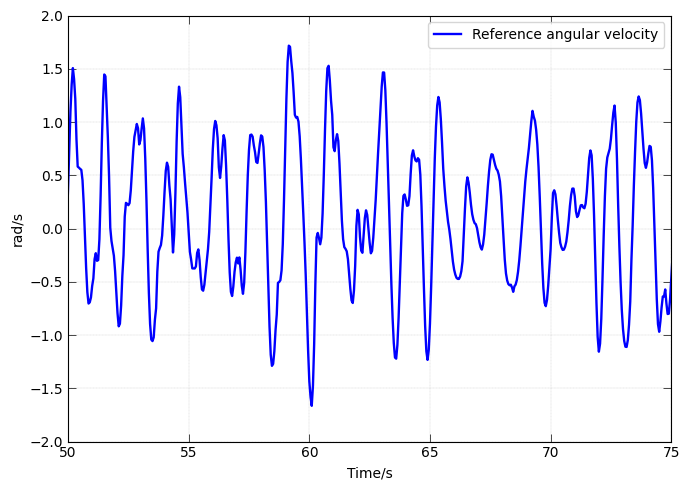

In [5]:
plt.figure(figsize=(7, 5))
plt.plot(time, theta_dot_ref, 
         label='Reference angular velocity', color='blue', linewidth=1.7)
# plt.plot(time, theta_dot, '--',
#          label='Float angular velocity', color='orange', linewidth=1.7)

plt.xlabel('Time/s')
plt.ylabel('rad/s')
plt.grid(True, which='both', linestyle='--', linewidth=0.2)
plt.legend(loc='upper right', fontsize=10)

plt.tick_params(axis='both', which='both', direction='in', 
                length=6, width=0.5, top=True, right=True)

# plt.axhline(0, color='black', lw=1, ls='--')
plt.xlim(left=50, right=75)
plt.ylim(bottom=-2, top=2)
# plt.title('Wave Excitation Moment (WEM) Over Time')
plt.tight_layout()
plt.show()

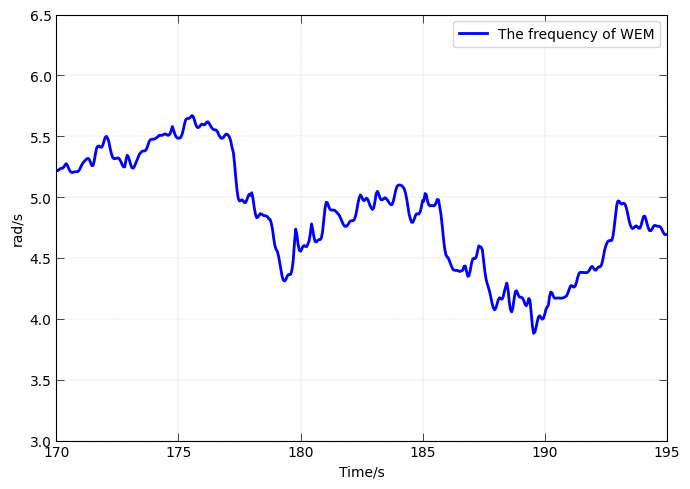

In [6]:
plt.figure(figsize=(7, 5))

plt.plot(time, omega_ekf, label='The frequency of WEM', color='blue', linewidth=2)
plt.xlabel('Time/s')
plt.ylabel('rad/s')
plt.grid(True, which='both', linestyle='--', linewidth=0.2)
plt.legend(loc='upper right', fontsize=10)

plt.tick_params(axis='both', which='both', direction='in', 
                length=6, width=0.5, top=True, right=True)


# plt.axhline(0, color='black', lw=1, ls='--')
plt.xlim(left=170, right=195)
plt.ylim(bottom=3, top=6.5)
# plt.title('Wave Excitation Moment (WEM) Over Time')
plt.tight_layout()
plt.show()

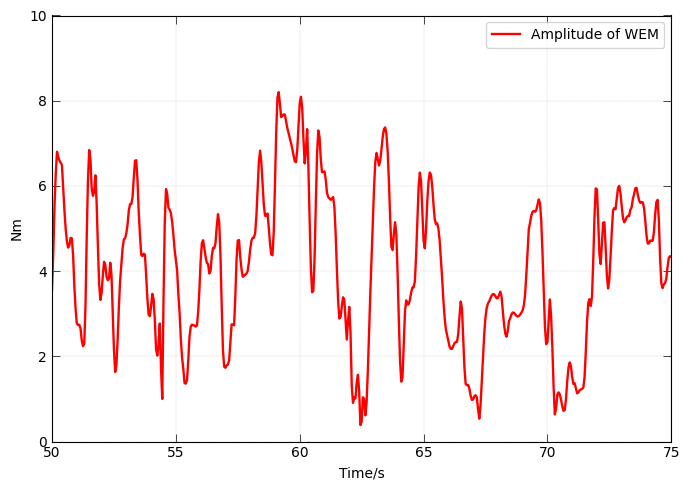

In [7]:
plt.figure(figsize=(7, 5))

plt.plot(time, amp_ekf, label='Amplitude of WEM', color='red', linewidth=1.7)
plt.xlabel('Time/s')
plt.ylabel('Nm')
plt.grid(True, which='both', linestyle='--', linewidth=0.2)
plt.legend(loc='upper right', fontsize=10)

plt.tick_params(axis='both', which='both', direction='in', 
                length=6, width=0.5, top=True, right=True)


# plt.axhline(0, color='black', lw=1, ls='--')
plt.xlim(left=50, right=75)
plt.ylim(bottom=0, top=10)
# plt.title('Wave Excitation Moment (WEM) Over Time')
plt.tight_layout()
plt.show()

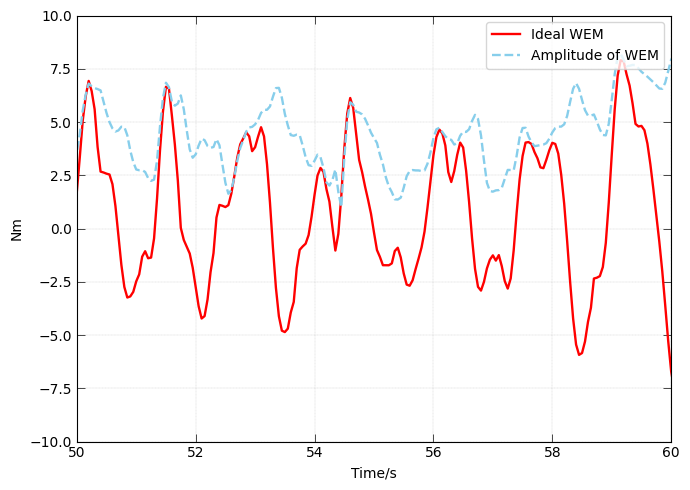

In [8]:
plt.figure(figsize=(7, 5))
plt.plot(time, wem, label='Ideal WEM', color='red', linewidth=1.7)
plt.plot(time, amp_ekf, '--', label='Amplitude of WEM', color='skyblue', linewidth=1.7)
plt.xlabel('Time/s')
plt.ylabel('Nm')
plt.grid(True, which='both', linestyle='--', linewidth=0.2)
plt.legend(loc='upper right', fontsize=10)

plt.tick_params(axis='both', which='both', direction='in', 
                length=6, width=0.5, top=True, right=True)


# plt.axhline(0, color='black', lw=1, ls='--')
plt.xlim(left=50, right=60)
plt.ylim(bottom=-10, top=10)
plt.tight_layout()
plt.show()

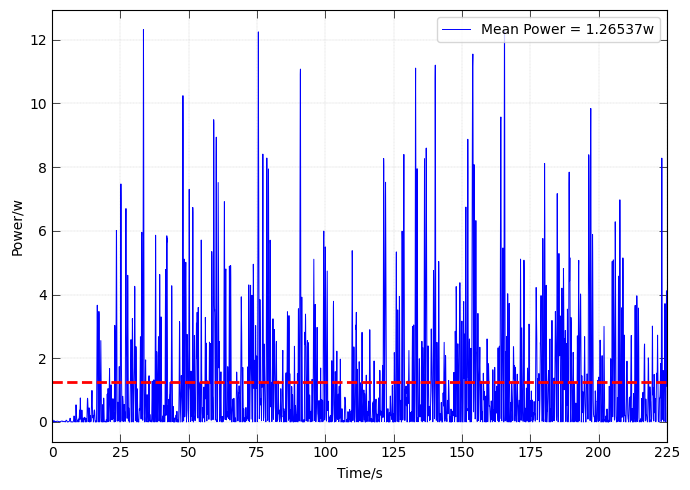

In [9]:
plt.figure(figsize=(7, 5))
plt.plot(time, power, color='blue', 
         label=f'Mean Power = {round(np.mean(power), 5)}w', linewidth=0.7)

plt.xlabel('Time/s')
plt.ylabel('Power/w')
plt.grid(True, which='both', linestyle='--', linewidth=0.2)
plt.legend(loc='upper right', fontsize=10)

plt.tick_params(axis='both', which='both', direction='in', 
                length=6, width=0.5, top=True, right=True)

plt.axhline(np.mean(power), color='red', lw=2, ls='--')
plt.xlim(left=0, right=max(time))
# plt.ylim(bottom=-2, top=2)
# plt.title('Wave Excitation Moment (WEM) Over Time')
plt.tight_layout()
plt.show()

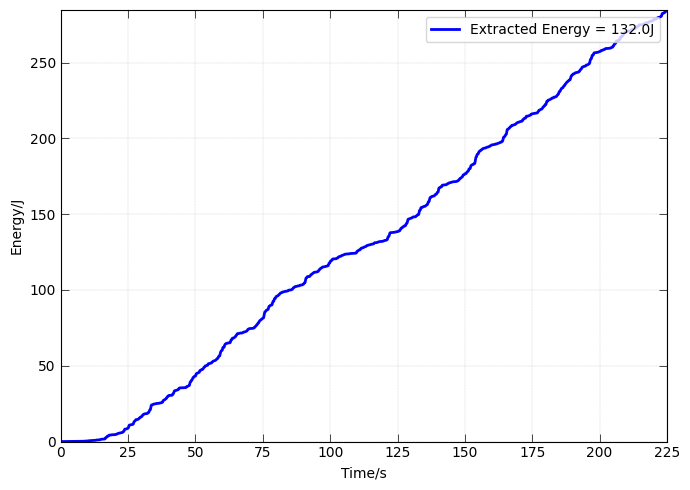

In [10]:
plt.figure(figsize=(7, 5))
plt.plot(time, energy, color='blue', 
         label=f'Extracted Energy = {round(np.mean(energy), 1)}J', linewidth=2)

plt.xlabel('Time/s')
plt.ylabel('Energy/J')
plt.grid(True, which='both', linestyle='--', linewidth=0.2)
plt.legend(loc='upper right', fontsize=10)

plt.tick_params(axis='both', which='both', direction='in', 
                length=6, width=0.5, top=True, right=True)

# plt.axhline(np.mean(power), color='red', lw=2, ls='--')
plt.xlim(left=0, right=max(time))
plt.ylim(bottom=0, top=max(energy))
# plt.title('Wave Excitation Moment (WEM) Over Time')
plt.tight_layout()
plt.show()

In [14]:
df.to_excel('wec_results.xlsx', index=False)

#### Gaussian Process modelling for WEM

### Gaussian Process Prediction (GPyTorch)

Given a new input vector **x**, the predictive mean of the GP model is:

$$
\mu(x) = \sum_{i=1}^{N} \alpha_i \cdot k(x, x_i)
$$

Where:

- $N$: number of training points
- $\alpha = [K + \sigma_n^2 I]^{-1} y$ is the weight vector
- $x_i$: i-th training input
- $y$: training targets
- $k(x, x_i)$: kernel function between $x$ and training point $x_i$
- $\sigma_n^2$: noise variance
- $K$: kernel matrix $K_{ij} = k(x_i, x_j)$

---

### Kernel Function (RBF with output scale)

Assuming you used a `ScaleKernel(RBFKernel())`, the kernel becomes:

$$
k(x, x') = \sigma_f^2 \cdot \exp\left( -\frac{1}{2\ell^2} \|x - x'\|^2 \right)
$$

Where:

- $\sigma_f^2$: output scale (signal variance)
- $\ell$: lengthscale of the RBF kernel

---

### Final Expression

Substitute into the predictive mean:

$$
\hat{y}(x) = \sum_{i=1}^{N} \alpha_i \cdot \sigma_f^2 \cdot \exp\left( -\frac{1}{2\ell^2} \|x - x_i\|^2 \right)
$$

---

### How to Compute:

1. Extract:
   - $\sigma_f^2$ = `model.covar_module.outputscale.item()`
   - $\ell$ = `model.covar_module.base_kernel.lengthscale.item()`
   - $\sigma_n^2$ = `model.likelihood.noise.item()`

2. Compute the kernel matrix:
   ```python
   K = model.covar_module(X_train).evaluate()
   K_noise = K + sigma_n**2 * torch.eye(len(X_train))
   alpha = torch.linalg.solve(K_noise, y_train)


# Model Building

In [ ]:
# This cell implements a Gaussian Process (GP) regression model to predict future values of the Wave Excitation Moment (WEM) time series.
# It first defines functions for creating lagged features (for autoregressive modeling), the GP regression model class, training, and prediction.
# The code prepares the data by constructing lagged input features and targets, splits the data into training and test sets, and converts them to PyTorch tensors.
# It then trains the GP model on the training data and prepares for evaluation. The model uses the Squared Exponential kernel to capture the relationships in the data.
# This step is crucial for the project as it enables probabilistic, data-driven forecasting of WEM, which is essential for understanding, modeling, and potentially controlling the system's behavior under uncertainty.

import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def create_lagged_features(wem, n_lags=3, pred_horizon=1):
    X, y = [], []
    for i in range(n_lags, len(wem) - pred_horizon):
        X.append(wem[i - n_lags:i])  # lagged inputs
        y.append(wem[i + pred_horizon])  # future target
    return np.array(X), np.array(y)


class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        
        # ARD Squared Exponential Kernel (RBF)
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=train_x.shape[1])
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def train_gp_model(train_x, train_y, training_iter=100):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPRegressionModel(train_x, train_y, likelihood)

    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        if i % 10 == 0:
            print(f'Iter {i + 1}/{training_iter} - Loss: {loss.item():.3f}')
        optimizer.step()

    return model, likelihood


def predict_gp(model, likelihood, test_x, test_y):
    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds = likelihood(model(test_x))
        mean = preds.mean
        lower, upper = preds.confidence_region()

    plt.figure(figsize=(10, 5))
    plt.plot(test_y.numpy(), label='Reference WEM')
    plt.plot(mean.numpy(), label='Predicted WEM with GP')
    # plt.fill_between(np.arange(len(mean)), lower.numpy(), upper.numpy(), alpha=0.2)
    plt.xlabel('Test Index')
    plt.ylabel('Nm')
    plt.legend()
    plt.tight_layout()
    plt.show()


np.random.seed(0)

#create features and targets
n_lags = 2
pred_horizon = 1
X, y = create_lagged_features(wem, n_lags=n_lags, pred_horizon=pred_horizon)

#train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

#torch tensors
train_x = torch.from_numpy(X_train).float()
train_y = torch.from_numpy(y_train).float()
test_x = torch.from_numpy(X_test).float()
test_y = torch.from_numpy(y_test).float()

model, likelihood = train_gp_model(train_x, train_y, training_iter=100)

Iter 1/100 - Loss: 1.310
Iter 11/100 - Loss: 1.187
Iter 21/100 - Loss: 1.163
Iter 31/100 - Loss: 1.154
Iter 41/100 - Loss: 1.149
Iter 51/100 - Loss: 1.147
Iter 61/100 - Loss: 1.146
Iter 71/100 - Loss: 1.145
Iter 81/100 - Loss: 1.145
Iter 91/100 - Loss: 1.144


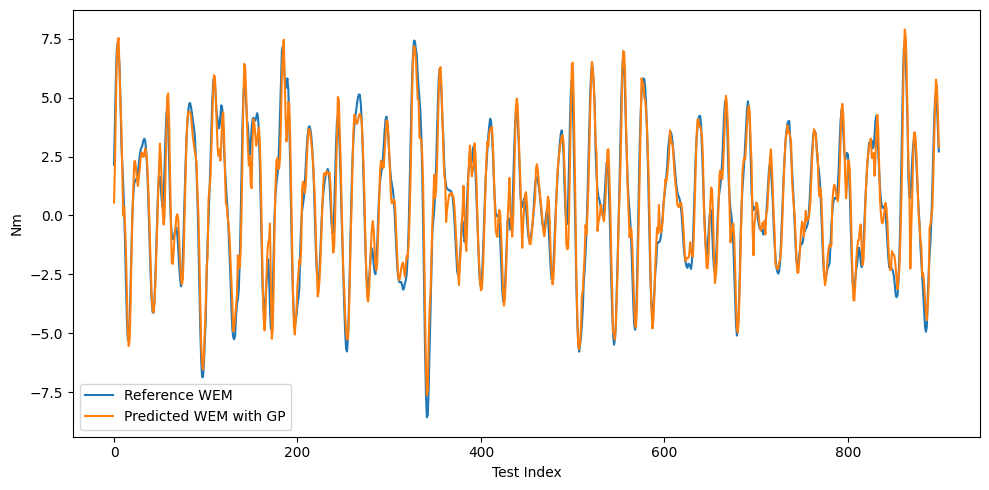

In [17]:
predict_gp(model, likelihood, test_x, test_y)

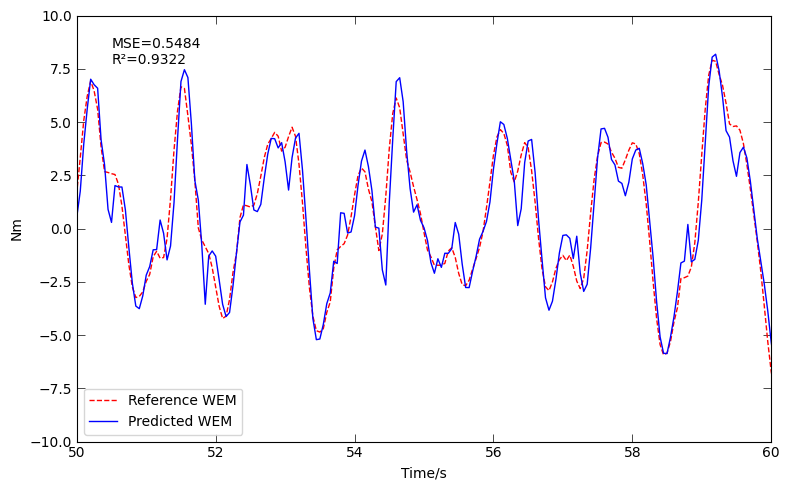

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

def predict_gp(model, likelihood, test_x, test_y, time):
    model.eval()
    likelihood.eval()

    t = time[len(time) - len(test_y):]  

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds = likelihood(model(test_x))
        mean = preds.mean
        lower, upper = preds.confidence_region()

    plt.figure(figsize=(7, 5))
    plt.plot(t, test_y.numpy(), '--', label='Reference WEM', color='red', linewidth=1)
    plt.plot(t, mean.numpy(), label='Predicted WEM', color='blue', linewidth=1)
    plt.xlim(50, 60)
    plt.ylim(-10, 10)
    plt.tick_params(axis='both', which='both', direction='in', 
                length=6, width=0.5, top=True, right=True)
    plt.text(0.05, 0.95, f'MSE={mean_squared_error(test_y.numpy(), mean.numpy()):.4f}\nR²={r2_score(test_y.numpy(), mean.numpy()):.4f}', 
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    # plt.fill_between(np.arange(len(mean)), lower.numpy(), upper.numpy(), alpha=0.2)
    plt.xlabel('Time/s')
    plt.ylabel('Nm')
    # plt.title('Predicted WEM')
    plt.legend(loc='lower left', fontsize=10)
    plt.tight_layout()
    plt.show()

predict_gp(model, likelihood, torch.from_numpy(X).float(), torch.from_numpy(y).float(), time)


### Gaussian Processing for Reference velocity

This cell builds and trains a Gaussian Process (GP) regression model to predict the reference angular velocity (θ̇_ref) of the wave energy converter (WEC) system using key physical features.
 
1. It prepares the input features (wem, amplitude, frequency, and inverse period) and the target (θ̇_ref) from the processed DataFrame.
2. The data is split into training and test sets, and converted to PyTorch tensors for compatibility with GPyTorch.
3. A GP regression model with an RBF kernel is defined and trained on the training data.
4. The cell includes a prediction and plotting function to visualize the model's performance on test data.

This step is important because it enables probabilistic, data-driven prediction of the optimal reference velocity for the WEC, leveraging both physical signal features and the uncertainty quantification capabilities of Gaussian Processes. This supports robust control and forecasting in the presence of real-world variability and noise.


In [ ]:

import torch
from sklearn.model_selection import train_test_split

torch.manual_seed(42)

X = df[['wem', 'amplitude', 'frequency', 'period']].values
y = df['ref_velocity'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Convert to torch tensors
train_x = torch.tensor(X_train, dtype=torch.float32)
train_y = torch.tensor(y_train, dtype=torch.float32)
test_x = torch.tensor(X_test, dtype=torch.float32)
test_y = torch.tensor(y_test, dtype=torch.float32)


class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=train_x.shape[1])
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(train_x, train_y, likelihood)

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(100):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    if i % 10 == 0:
        print(f'Iter {i+1}/100 - Loss: {loss.item():.4f}')
    optimizer.step()

def predict_gp(model, likelihood, test_x, test_y, time):
    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds = likelihood(model(test_x))
        mean = preds.mean
        lower, upper = preds.confidence_region()

    import matplotlib.pyplot as plt
    plt.figure(figsize=(7, 5))
    plt.plot(time, test_y.numpy(), label='True θ̇_ref', color='black')
    plt.plot(time, mean.numpy(), label='Predicted θ̇_ref', linestyle='--', color='blue')
    # plt.fill_between(np.arange(len(mean)), lower.numpy(), upper.numpy(), alpha=0.2, label='±2σ')
    plt.xlim(50, 60)
    # plt.ylim(-10, 10)
    plt.tick_params(axis='both', which='both', direction='in', 
                length=6, width=0.5, top=True, right=True)
    plt.text(0.05, 0.95, f'MSE={mean_squared_error(test_y.numpy(), mean.numpy()):.4f}\nR²={r2_score(test_y.numpy(), mean.numpy()):.4f}', 
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    # plt.fill_between(np.arange(len(mean)), lower.numpy(), upper.numpy(), alpha=0.2)
    plt.xlabel('Time/s')
    plt.ylabel('rad/s')
    plt.legend()
    plt.tight_layout()
    plt.show()


Iter 1/100 - Loss: 0.8148
Iter 11/100 - Loss: 0.3793
Iter 21/100 - Loss: -0.1017
Iter 31/100 - Loss: -0.6059
Iter 41/100 - Loss: -1.1290
Iter 51/100 - Loss: -1.6470
Iter 61/100 - Loss: -2.1535
Iter 71/100 - Loss: -2.6139
Iter 81/100 - Loss: -2.9970
Iter 91/100 - Loss: -3.2622


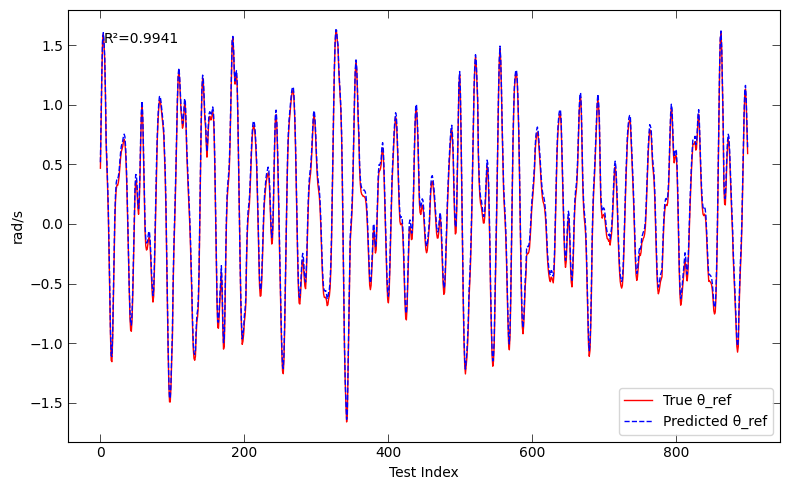

In [27]:
def predict_gp(model, likelihood, test_x, test_y):
    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds = likelihood(model(test_x))
        mean = preds.mean
        lower, upper = preds.confidence_region()

    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 5))
    plt.plot(test_y.numpy(), label='True θ̇_ref', color='red', linewidth=1)
    plt.plot(mean.numpy(), label='Predicted θ̇_ref', linestyle='--', color='blue', linewidth=1)
    # plt.fill_between(np.arange(len(mean)), lower.numpy(), upper.numpy(), alpha=0.2, label='±2σ')
    # plt.xlim(50, 60)
    # plt.ylim(-10, 10)
    plt.tick_params(axis='both', which='both', direction='in', 
                length=6, width=0.5, top=True, right=True)
    plt.text(0.05, 0.95, f'R²={r2_score(test_y.numpy(), mean.numpy()):.4f}', 
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    # plt.fill_between(np.arange(len(mean)), lower.numpy(), upper.numpy(), alpha=0.2)
    plt.xlabel('Test Index')
    plt.ylabel('rad/s')
    plt.legend()
    plt.tight_layout()
    plt.show()

predict_gp(model, likelihood, test_x, test_y)


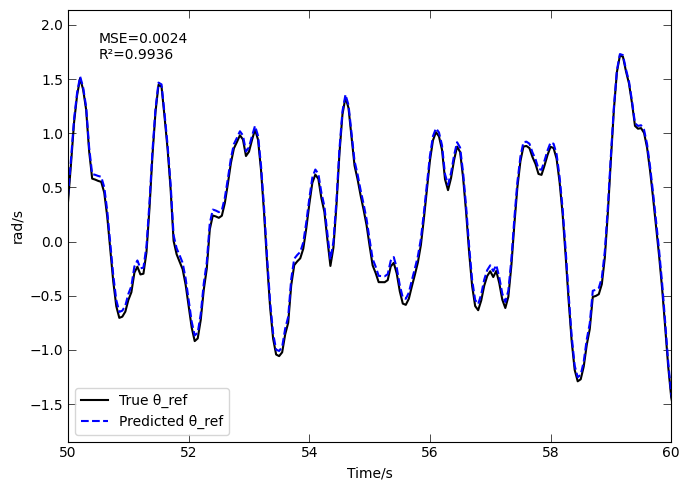

In [ ]:
predict_gp(model, likelihood, torch.tensor(X, dtype=torch.float32),
            torch.tensor(y, dtype=torch.float32), time)


### LSTM for WEM modelling

In [ ]:
# This cell implements an LSTM-based time series forecasting model for the Wave Excitation Moment (WEM).
# 
# 1. It defines a function to create supervised learning datasets from the WEM time series using lagged windows.
# 2. It builds an LSTM neural network for sequence-to-sequence regression, suitable for capturing temporal dependencies in the WEM data.
# 3. The code prepares the data, splits it into training and test sets, and sets up a PyTorch DataLoader for efficient mini-batch training.
# 4. The LSTM model is trained to predict future WEM values based on past observations.
# 5. A plotting function is provided to visualize the LSTM's forecasting performance against the true WEM values.
#
# This step is important because LSTM networks are powerful for modeling complex, nonlinear temporal dependencies in time series data.
# By leveraging LSTM, the project can relace GP models for robust, data-driven forecasting of WEM, which is crucial for downstream tasks such as control, optimization, and uncertainty quantification in wave energy conversion systems.

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

torch.manual_seed(42)

def create_sequence_dataset(wem, n_lags=3, pred_horizon=1):
    X, y = [], []
    for i in range(len(wem) - n_lags - pred_horizon):
        X.append(wem[i:i + n_lags])
        y.append(wem[i + n_lags:i + n_lags + pred_horizon])
    return np.array(X), np.array(y)


class LSTMRegression(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_len=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_len)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # use last output
        out = self.fc(out)
        return out

def train_lstm(model, train_loader, n_epochs=100, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(n_epochs):
        model.train()
        for xb, yb in train_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{n_epochs} - Loss: {loss.item():.4f}")


def plot_lstm_forecast(model, X_test, y_test, time):

    t =  time[len(time) - len(y_test):]
    model.eval()
    with torch.no_grad():
        pred = model(X_test).flatten()
        true = y_test.numpy()

    plt.figure(figsize=(7, 5))
    plt.plot(t, true, label='True WEM')
    plt.plot(t, pred, '--', label='LSTM Forecast')
    plt.xlim(50, 60)
    plt.ylim(-10, 10)
    plt.tick_params(axis='both', which='both', direction='in', 
                length=6, width=0.5, top=True, right=True)
    plt.text(0.05, 0.95, f'MSE={mean_squared_error(true, pred):.4f}\nR²={r2_score(true, pred.numpy()):.4f}', 
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    # plt.fill_between(np.arange(len(mean)), lower.numpy(), upper.numpy(), alpha=0.2)
    plt.xlabel('Time/s')
    plt.ylabel('Nm')
    # plt.title('Predicted WEM')
    plt.legend(loc='lower left', fontsize=10)
    plt.tight_layout()
    plt.show()

n_lags = 2
pred_horizon = 1
X, y = create_sequence_dataset(wem, n_lags=n_lags, pred_horizon=pred_horizon)

X = torch.tensor(X[:, :, None], dtype=torch.float32)  # shape: (N, n_lags, 1)
y = torch.tensor(y, dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train, y_train),
    batch_size=32, shuffle=True
)

#train
model = LSTMForecaster(input_size=1, output_len=pred_horizon)
train_lstm(model, train_loader, n_epochs=100, lr=1e-3)


Epoch 1/100 - Loss: 0.8048
Epoch 11/100 - Loss: 0.0705
Epoch 21/100 - Loss: 0.0790
Epoch 31/100 - Loss: 0.0608
Epoch 41/100 - Loss: 0.1291
Epoch 51/100 - Loss: 0.1233
Epoch 61/100 - Loss: 0.1346
Epoch 71/100 - Loss: 0.1494
Epoch 81/100 - Loss: 0.1294
Epoch 91/100 - Loss: 0.0997


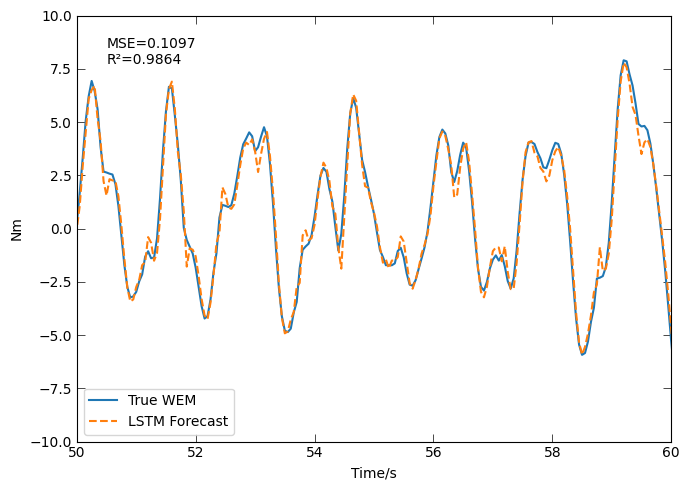

In [29]:
plot_lstm_forecast(model, torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32), time)


Comparing  the LSTM result with the benchmark GP model shows that the LSTM model has higher accuracy in modelling WEM than the GP model. 

### LSTM for reference veolocity modelling

Epoch 0: Loss = 0.0909
Epoch 10: Loss = 0.0110
Epoch 20: Loss = 0.0093
Epoch 30: Loss = 0.0087
Epoch 40: Loss = 0.0086
Epoch 50: Loss = 0.0078
Epoch 60: Loss = 0.0077
Epoch 70: Loss = 0.0078
Epoch 80: Loss = 0.0076
Epoch 90: Loss = 0.0073


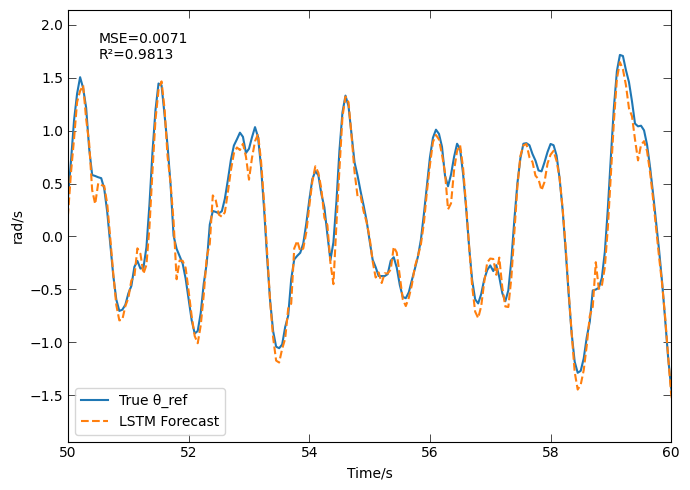

In [ ]:
# This cell implements an LSTM-based sequence model to predict the reference angular velocity (θ̇_ref) of the wave energy converter (WEC) system using multiple physical features.
# 
# 1. It defines a function to create supervised learning datasets from the DataFrame using lagged windows of features (wem, amplitude, frequency, period).
# 2. It builds an LSTM neural network for sequence-to-one regression, suitable for capturing temporal dependencies in the input features.
# 3. The code prepares the data, splits it into training and test sets, and sets up a PyTorch DataLoader for efficient mini-batch training.
# 4. The LSTM model is trained to predict θ̇_ref based on past sequences of physical features.
# 5. A plotting function is provided to visualize the LSTM's forecasting performance against the true θ̇_ref values.
#
# This step is important because LSTM networks are powerful for modeling complex, nonlinear temporal dependencies in multivariate time series data.
# By leveraging LSTM, the project can robustly forecast the optimal reference velocity for the WEC, supporting advanced control and optimization strategies under real-world variability and noise.
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
torch.manual_seed(42)

def create_lstm_sequences(df, features, target_col, seq_len=10):
    X, y = [], []
    for i in range(seq_len, len(df)):
        X.append(df[features].iloc[i-seq_len:i].values)
        y.append(df[target_col].iloc[i])
    return np.array(X), np.array(y)

class LSTMRegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout)

        # Feedforward tail
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size // 2, 1)

    def forward(self, x):
        out, _ = self.lstm(x)  # shape: (B, T, H)
        last_output = out[:, -1, :]  # shape: (B, H)
        last_output = self.norm(last_output)
        last_output = self.dropout(last_output)
        x = self.relu(self.fc1(last_output))
        x = self.fc2(x)
        return x.squeeze(1)

def train_lstm(model, train_loader, val_loader, n_epochs=100, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    for epoch in range(n_epochs):
        model.train()
        train_losses, val_losses = [], []
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            output = model(batch_x)
            loss = loss_fn(output, batch_y)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        
        for batch_x, batch_y in val_loader:
            model.eval()
            with torch.no_grad():
                output = model(batch_x)
                val_loss = loss_fn(output, batch_y)
            val_losses.append(val_loss.item())
        if epoch % 10 == 0:
            print(f'Epoch {epoch+1}/{n_epochs} - Train Loss: {np.mean(train_losses):.4f}, Val Loss: {val_loss.item():.4f}')



def plot_lstm_forecast(model, X_test, y_test, time):

    t =  time[len(time) - len(y_test):]
    model.eval()
    with torch.no_grad():
        pred = model(X_test).flatten()
        true = y_test.numpy()

    plt.figure(figsize=(7, 5))
    plt.plot(t, true, label='True θ̇_ref')
    plt.plot(t, pred, '--', label='LSTM Forecast')
    plt.xlim(50, 60)
    # plt.ylim(-10, 10)
    plt.tick_params(axis='both', which='both', direction='in', 
                length=6, width=0.5, top=True, right=True)
    plt.text(0.05, 0.95, f'MSE={mean_squared_error(true, pred):.4f}\nR²={r2_score(true, pred.numpy()):.4f}', 
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    # plt.fill_between(np.arange(len(mean)), lower.numpy(), upper.numpy(), alpha=0.2)
    plt.xlabel('Time/s')
    plt.ylabel('rad/s')
    plt.legend(loc='lower left', fontsize=10)
    plt.tight_layout()
    plt.show()

# Feature setup
features = ['wem', 'amplitude', 'frequency', 'period']
target = 'ref_velocity'
seq_len = 2

# Create sequences
X, y = create_lstm_sequences(df, features, target, seq_len)

# Convert to torch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train, y_train),
    batch_size=64, shuffle=True
)

# Train model
model = LSTMRefVelocityModel(input_size=X.shape[2])
train_lstm(model, train_loader)

plot_lstm_forecast(model, torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32), time)


### GRU for reference velocity modelling

In [ ]:
# This cell implements a GRU-based neural network for time series regression to model and predict the reference angular velocity (θ̇_ref) of the wave energy converter (WEC).
#
# 1. It defines a function to create supervised learning datasets from the processed DataFrame, using lagged sequences of physical features (wem, amplitude, frequency, and inverse period) as input and θ̇_ref as the target.
# 2. It builds a GRU neural network for sequence-to-one regression, suitable for capturing temporal dependencies in the input features.
# 3. The code prepares the data, splits it into training and test sets, and sets up a PyTorch DataLoader for efficient mini-batch training.
# 4. The GRU model is trained to predict future θ̇_ref values based on past sequences of physical features.
#
# This step is important because GRU networks are effective for modeling sequential data and capturing temporal dependencies in multivariate time series. By leveraging GRU, the project enables robust, data-driven forecasting of the optimal reference velocity for the WEC, supporting improved control and energy extraction under real-world variability.

import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split

torch.manual_seed(42)

def create_gru_sequences(df, features, target_col, seq_len=2):
    X, y = [], []
    data = df[features + [target_col]].values
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len, :-1])     # sequence of features
        y.append(data[i+seq_len, -1])        # target at current time
    return np.array(X), np.array(y)

class GRURegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.3):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout)

        # Feedforward tail
        self.head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 1)
        )

    def forward(self, x):
        gru_out, _ = self.gru(x)                  # (B, T, H)
        last_timestep = gru_out[:, -1, :]         # (B, H)
        x = self.norm(last_timestep)
        x = self.dropout(x)
        return self.head(x).squeeze()


def train_gru(model, train_loader, n_epochs=100, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(n_epochs):
        model.train()
        for xb, yb in train_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{n_epochs} - Loss: {loss.item():.4f}")

# Features and target
features = ['wem', 'amplitude', 'frequency', 'period']
target = 'ref_velocity'
seq_len = 2

# Create dataset
X, y = create_gru_sequences(df, features, target_col=target, seq_len=seq_len)

# Torch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# DataLoader
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train, y_train),
    batch_size=32, shuffle=True
)

# Model
model = GRURegressionModel(input_size=X.shape[2])
train_gru(model, train_loader, n_epochs=100)

Epoch 1/100 - Loss: 0.0435
Epoch 11/100 - Loss: 0.0048
Epoch 21/100 - Loss: 0.0100
Epoch 31/100 - Loss: 0.0097
Epoch 41/100 - Loss: 0.0097
Epoch 51/100 - Loss: 0.0104
Epoch 61/100 - Loss: 0.0021
Epoch 71/100 - Loss: 0.0133
Epoch 81/100 - Loss: 0.0063
Epoch 91/100 - Loss: 0.0037


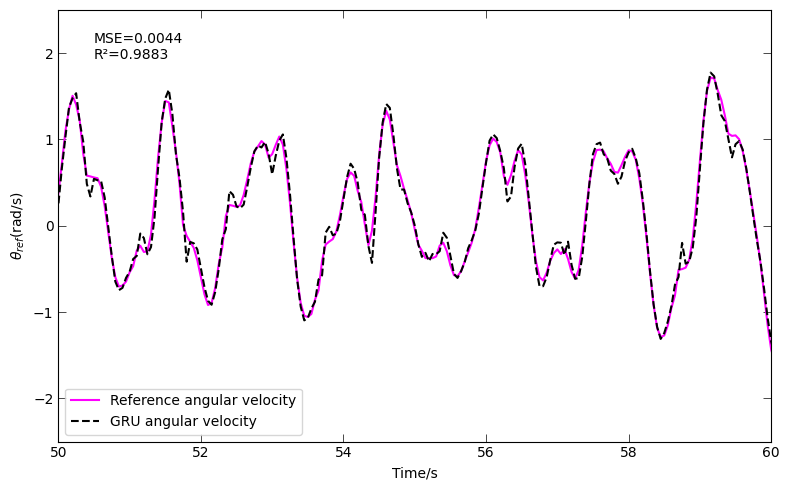

In [16]:
from sklearn.metrics import mean_squared_error, r2_score
def plot_lstm_forecast(model, X_test, y_test, time):

    t =  time[len(time) - len(y_test):]
    model.eval()
    with torch.no_grad():
        pred = model(X_test).flatten()
        true = y_test.numpy()

    plt.figure(figsize=(8, 5))
    plt.plot(t, true, color='magenta', label='Reference angular velocity')
    plt.plot(t, pred, '--', color='black',label='GRU angular velocity')
    plt.xlim(50, 60)
    plt.ylim(-2.50, 2.50)
    plt.tick_params(axis='both', which='both', direction='in', 
                length=6, width=0.5, top=True, right=True)
    plt.text(0.05, 0.95, f'MSE={mean_squared_error(true, pred):.4f}\nR²={r2_score(true, pred.numpy()):.4f}', 
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    # plt.fill_between(np.arange(len(mean)), lower.numpy(), upper.numpy(), alpha=0.2)
    plt.xlabel('Time/s')
    plt.ylabel('$\\theta_{ref}$(rad/s)')
    # plt.title('Predicted WEM')
    plt.legend(loc='lower left', fontsize=10)
    plt.tight_layout()
    plt.show()

plot_lstm_forecast(model, torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32), time)


### GRU for WEM

In [17]:
def create_wem_sequences(wem_array, seq_len=2):
    X, y = [], []
    for i in range(len(wem_array) - seq_len):
        X.append(wem_array[i:i+seq_len])
        y.append(wem_array[i+seq_len])
    return np.array(X), np.array(y)

class GRUWEMPredictor(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, dropout=0.2):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers,
                          batch_first=True, dropout=dropout)
        self.norm = nn.LayerNorm(hidden_size)
        self.fc = nn.Sequential(
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 1)
        )

    def forward(self, x):
        out, _ = self.gru(x)
        x = self.norm(out[:, -1, :])
        return self.fc(x).squeeze()

def train_wem(model, train_loader, n_epochs=100, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(n_epochs):
        model.train()
        for xb, yb in train_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{n_epochs} - Loss: {loss.item():.4f}")


def plot_wem_forecast(model, X_test, y_test, time):

    t =  time[len(time) - len(y_test):]
    model.eval()
    with torch.no_grad():
        pred = model(X_test).flatten()
        true = y_test.numpy()

    plt.figure(figsize=(7, 5))
    plt.plot(t, true, label='True WEM')
    plt.plot(t, pred, '--', label='GRU Forecast')
    plt.xlim(50, 60)
    plt.ylim(-10, 10)
    plt.tick_params(axis='both', which='both', direction='in', 
                length=6, width=0.5, top=True, right=True)
    plt.text(0.05, 0.95, f'MSE={mean_squared_error(true, pred):.4f}\nR²={r2_score(true, pred.numpy()):.4f}', 
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    # plt.fill_between(np.arange(len(mean)), lower.numpy(), upper.numpy(), alpha=0.2)
    plt.xlabel('Time/s')
    plt.ylabel('Nm')
    # plt.title('Predicted WEM')
    plt.legend(loc='lower left', fontsize=10)
    plt.tight_layout()
    plt.show()

n_lags = 2
pred_horizon = 1


# Create sequences
X, y = create_wem_sequences(wem, n_lags)
X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # (N, T, 1)
y = torch.tensor(y, dtype=torch.float32)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Dataloader
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train, y_train),
    batch_size=32, shuffle=True
)

# Train GRU model
model = GRUWEMPredictor()
train_wem(model, train_loader)



Epoch 1/100 - Loss: 0.2035
Epoch 11/100 - Loss: 0.1118
Epoch 21/100 - Loss: 0.0978
Epoch 31/100 - Loss: 0.0846
Epoch 41/100 - Loss: 0.1364
Epoch 51/100 - Loss: 0.0754
Epoch 61/100 - Loss: 0.1018
Epoch 71/100 - Loss: 0.0704
Epoch 81/100 - Loss: 0.1687
Epoch 91/100 - Loss: 0.1467


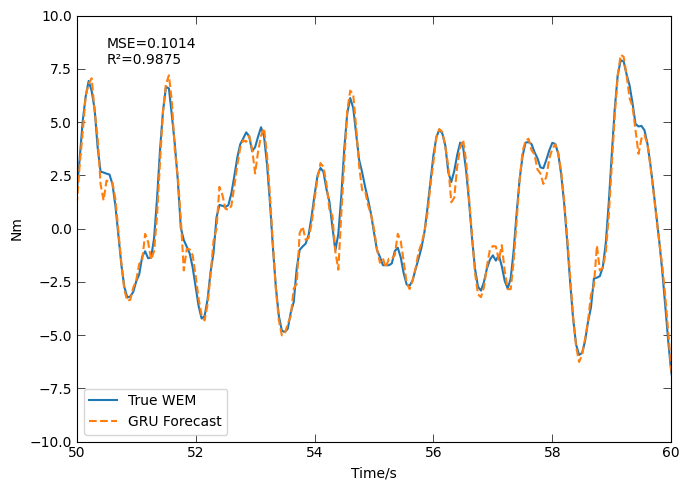

In [18]:
plot_wem_forecast(model, torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32), time)


## Transformer for $\theta_{ref}$

In [ ]:
def create_transformer_sequences(df, features, target_col, seq_len=10):
    X, y = [], []
    data = df[features + [target_col]].values
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len, :-1])
        y.append(data[i+seq_len, -1])
    return np.array(X), np.array(y)


class TransformerModel(nn.Module):
    def __init__(self, input_size, seq_len, d_model=64, nhead=4, 
                 num_layers=2, dim_feedforward=128, dropout=0.2):
        super().__init__()
        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(1, seq_len, d_model))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer,
                                                          num_layers=num_layers)

        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Linear(d_model // 2, 1)
        )

    def forward(self, x):  # x: (B, T, input_size)
        x = self.input_proj(x)  # (B, T, d_model)
        x = x + self.pos_embedding[:, :x.size(1), :]
        x = self.transformer_encoder(x)
        out = x[:, -1, :]  # Use last token
        return self.head(out).squeeze()

def train_transformer(model, train_loader, n_epochs=100, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    for epoch in range(n_epochs):
        model.train()
        losses = []
        for xb, yb in train_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss = {np.mean(losses):.4f}")


features = ['wem', 'amplitude', 'frequency', 'period']
target = 'ref_velocity'
seq_len = 2

# Create sequences
X, y = create_transformer_sequences(df, features, target, seq_len)
X = torch.tensor(X, dtype=torch.float32)  # (B, T, input_size)
y = torch.tensor(y, dtype=torch.float32)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train, y_train),
    batch_size=64, shuffle=True
)

# Model init
model = TransformerModel(input_size=X.shape[2], seq_len=seq_len)
train_transformer(model, train_loader)


Epoch 0: Loss = 0.0597
Epoch 10: Loss = 0.0093
Epoch 20: Loss = 0.0076
Epoch 30: Loss = 0.0067
Epoch 40: Loss = 0.0066
Epoch 50: Loss = 0.0063
Epoch 60: Loss = 0.0061
Epoch 70: Loss = 0.0059
Epoch 80: Loss = 0.0062
Epoch 90: Loss = 0.0056


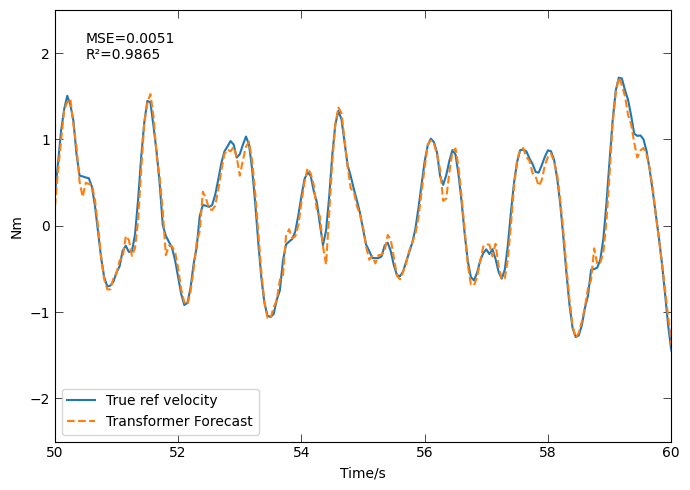

In [21]:
def plot_forecast(model, X_test, y_test, time):

    t =  time[len(time) - len(y_test):]
    model.eval()
    with torch.no_grad():
        pred = model(X_test).flatten()
        true = y_test.numpy()

    plt.figure(figsize=(7, 5))
    plt.plot(t, true, label='True ref velocity')
    plt.plot(t, pred, '--', label='Transformer Forecast')
    plt.xlim(50, 60)
    plt.ylim(-2.50, 2.50)
    plt.tick_params(axis='both', which='both', direction='in', 
                length=6, width=0.5, top=True, right=True)
    plt.text(0.05, 0.95, f'MSE={mean_squared_error(true, pred):.4f}\nR²={r2_score(true, pred.numpy()):.4f}', 
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    # plt.fill_between(np.arange(len(mean)), lower.numpy(), upper.numpy(), alpha=0.2)
    plt.xlabel('Time/s')
    plt.ylabel('Nm')
    # plt.title('Predicted WEM')
    plt.legend(loc='lower left', fontsize=10)
    plt.tight_layout()
    plt.show()
plot_forecast(model, torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32), time)


# Transformer for WEM

In [ ]:
def create_wem_transformer_sequences(wem_array, seq_len=10):
    X, y = [], []
    for i in range(len(wem_array) - seq_len):
        X.append(wem_array[i:i+seq_len])
        y.append(wem_array[i+seq_len])
    return np.array(X), np.array(y)

class Attention:
    pass

class ResidualBlockLayer:
    pass

class TransformerWEMPredictor(nn.Module):
    def __init__(self, seq_len, d_model=64, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.2):
        super().__init__()
        self.input_proj = nn.Linear(1, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(1, seq_len, d_model))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Linear(d_model // 2, 1)
        )

    def forward(self, x):  # x: (B, T, 1)
        x = self.input_proj(x)  # (B, T, d_model)
        x = x + self.pos_embedding[:, :x.size(1), :]
        x = self.encoder(x)
        return self.head(x[:, -1, :]).squeeze()

def train_transformer(model, train_loader, n_epochs=100, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    for epoch in range(n_epochs):
        model.train()
        losses = []
        for xb, yb in train_loader:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss = {np.mean(losses):.4f}")

# WEM signal (e.g., from df['wem'])
wem = df['wem'].values
seq_len = 2

# Create sequences
X, y = create_wem_transformer_sequences(wem, seq_len)
X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # (N, T, 1)
y = torch.tensor(y, dtype=torch.float32)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train, y_train),
    batch_size=64, shuffle=True
)

# Train model
model = TransformerWEMPredictor(seq_len=seq_len)
train_transformer(model, train_loader)


Epoch 0: Loss = 2.4116
Epoch 10: Loss = 0.1702
Epoch 20: Loss = 0.1724
Epoch 30: Loss = 0.1430
Epoch 40: Loss = 0.1293
Epoch 50: Loss = 0.1322
Epoch 60: Loss = 0.1285
Epoch 70: Loss = 0.1275
Epoch 80: Loss = 0.1221
Epoch 90: Loss = 0.1293


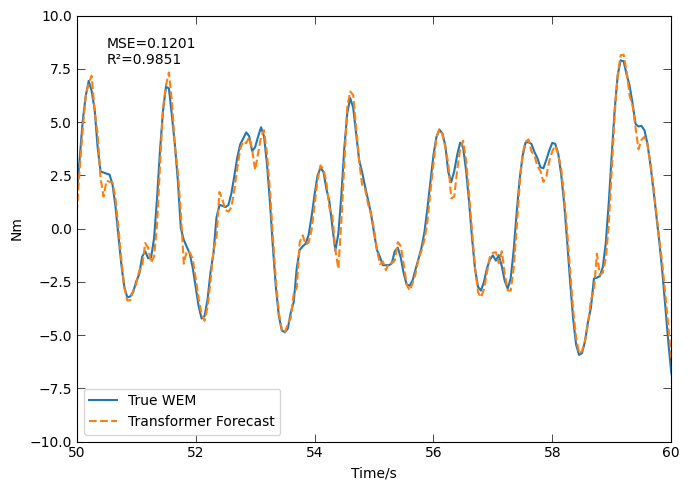

In [23]:
def plot_forecast(model, X_test, y_test, time):

    t =  time[len(time) - len(y_test):]
    model.eval()
    with torch.no_grad():
        pred = model(X_test).flatten()
        true = y_test.numpy()

    plt.figure(figsize=(7, 5))
    plt.plot(t, true, label='True WEM')
    plt.plot(t, pred, '--', label='Transformer Forecast')
    plt.xlim(50, 60)
    plt.ylim(-10, 10)
    plt.tick_params(axis='both', which='both', direction='in', 
                length=6, width=0.5, top=True, right=True)
    plt.text(0.05, 0.95, f'MSE={mean_squared_error(true, pred):.4f}\nR²={r2_score(true, pred.numpy()):.4f}', 
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    # plt.fill_between(np.arange(len(mean)), lower.numpy(), upper.numpy(), alpha=0.2)
    plt.xlabel('Time/s')
    plt.ylabel('Nm')
    # plt.title('Predicted WEM')
    plt.legend(loc='lower left', fontsize=10)
    plt.tight_layout()
    plt.show()
plot_forecast(model, torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32), time)
